In [6]:
# All Library or Packages
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest

In [18]:
# Prepare Dummy Data
df = pd.read_csv('./Data Dummy.csv')
start_time = datetime(2000, 1, 1, 0, 0, 0)
df["Datetime"] = df["Time"].apply(lambda x: start_time + timedelta(seconds=int(x)))

df['Month'] = df['Datetime'].dt.month
df['Hour'] = df['Datetime'].dt.hour
df['Minute'] = df['Datetime'].dt.minute
df['Second'] = df['Datetime'].dt.second

df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Second_sin'] = np.sin(2 * np.pi * df['Second'] / 60)


step = 3  
def rows_for(seconds):
    return seconds // step

df['LoadCell_lag_1m']  = df['Load Cell'].shift(rows_for(60))
df['LoadCell_lag_5m']  = df['Load Cell'].shift(rows_for(300))
df['LoadCell_lag_15m'] = df['Load Cell'].shift(rows_for(900))
df['LoadCell_lag_30m'] = df['Load Cell'].shift(rows_for(1800))
df['LoadCell_lag_1h']  = df['Load Cell'].shift(rows_for(3600))
df['LoadCell_lag_6h']  = df['Load Cell'].shift(rows_for(21600))

DROP_COLUMNS = ['Time', 'Month', 'Hour', 'Minute', 'Second']
df = df.drop(columns=DROP_COLUMNS)

df = df.dropna(subset=[
    'LoadCell_lag_1m',
    'LoadCell_lag_5m',
    'LoadCell_lag_15m',
    'LoadCell_lag_30m',
    'LoadCell_lag_1h',
    'LoadCell_lag_6h'
]).reset_index(drop=True)

df

,Load Cell,IsDetected,Temperatur,Datetime,Month_sin,Hour_sin,Minute_sin,Second_sin,LoadCell_lag_1m,LoadCell_lag_5m,LoadCell_lag_15m,LoadCell_lag_30m,LoadCell_lag_1h,LoadCell_lag_6h
0,0.000000,0,20.000000,2000-01-01 06:00:00,0.5,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0,20.000000,2000-01-01 06:00:03,0.5,1.0,0.000000,0.309017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0,20.000000,2000-01-01 06:00:06,0.5,1.0,0.000000,0.587785,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0,20.000001,2000-01-01 06:00:09,0.5,1.0,0.000000,0.809017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0,20.000002,2000-01-01 06:00:12,0.5,1.0,0.000000,0.951057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600274,247.421829,1,22.245775,2000-01-22 02:13:42,0.5,0.5,0.978148,-0.951057,247.438695,247.508687,247.669824,247.915218,248.419313,253.387796
600275,247.420335,1,22.244865,2000-01-22 02:13:45,0.5,0.5,0.978148,-1.000000,247.437372,247.507183,247.669686,247.913620,248.418149,253.386822
600276,247.419067,1,22.243955,2000-01-22 02:13:48,0.5,0.5,0.978148,-0.951057,247.437343,247.506994,247.668418,247.912210,248.418079,253.386692
600277,247.417995,1,22.243045,2000-01-22 02:13:51,0.5,0.5,0.978148,-0.809017,247.435983,247.505496,247.666813,247.912194,248.417425,253.386266


In [19]:
features = [
    "Load Cell", "Temperatur",
    "Month_sin", "Hour_sin", "Minute_sin", "Second_sin",
    "LoadCell_lag_1m", "LoadCell_lag_5m", "LoadCell_lag_15m",
    "LoadCell_lag_30m", "LoadCell_lag_1h", "LoadCell_lag_6h"
]

X = df[features]

iso = IsolationForest(
    n_estimators=100,      # jumlah pohon
    contamination=0.01,    # perkiraan proporsi anomali (1%)
    random_state=42
)

df["anomaly"] = iso.fit_predict(X)

df["anomaly_score"] = iso.decision_function(X)

df


,Load Cell,IsDetected,Temperatur,Datetime,Month_sin,Hour_sin,Minute_sin,Second_sin,LoadCell_lag_1m,LoadCell_lag_5m,LoadCell_lag_15m,LoadCell_lag_30m,LoadCell_lag_1h,LoadCell_lag_6h,anomaly,anomaly_score
0,0.000000,0,20.000000,2000-01-01 06:00:00,0.5,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,-0.045796
1,0.000000,0,20.000000,2000-01-01 06:00:03,0.5,1.0,0.000000,0.309017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,-0.045436
2,0.000000,0,20.000000,2000-01-01 06:00:06,0.5,1.0,0.000000,0.587785,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,-0.046772
3,0.000000,0,20.000001,2000-01-01 06:00:09,0.5,1.0,0.000000,0.809017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,-0.042952
4,0.000000,0,20.000002,2000-01-01 06:00:12,0.5,1.0,0.000000,0.951057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,-0.043791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600274,247.421829,1,22.245775,2000-01-22 02:13:42,0.5,0.5,0.978148,-0.951057,247.438695,247.508687,247.669824,247.915218,248.419313,253.387796,1,0.039662
600275,247.420335,1,22.244865,2000-01-22 02:13:45,0.5,0.5,0.978148,-1.000000,247.437372,247.507183,247.669686,247.913620,248.418149,253.386822,1,0.037678
600276,247.419067,1,22.243955,2000-01-22 02:13:48,0.5,0.5,0.978148,-0.951057,247.437343,247.506994,247.668418,247.912210,248.418079,253.386692,1,0.039662
600277,247.417995,1,22.243045,2000-01-22 02:13:51,0.5,0.5,0.978148,-0.809017,247.435983,247.505496,247.666813,247.912194,248.417425,253.386266,1,0.043325


In [20]:
df['anomaly'].value_counts()

anomaly
 1    594276
-1      6003
Name: count, dtype: int64

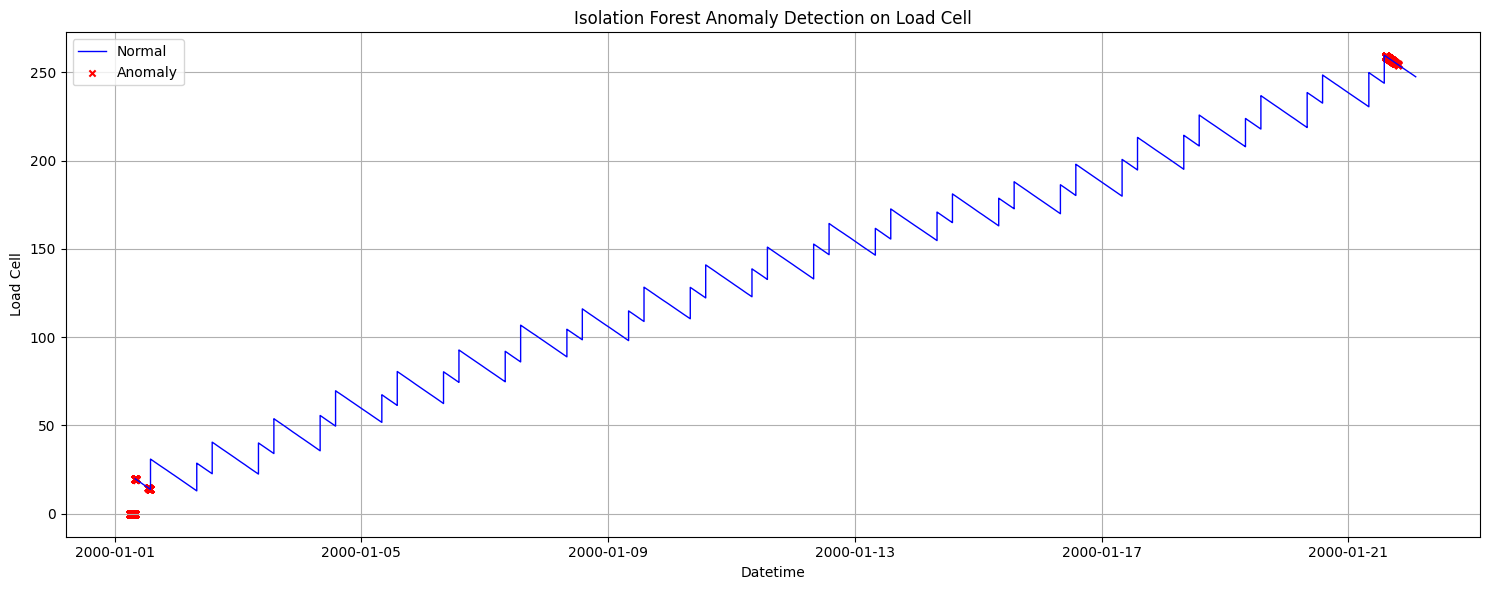

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Load hasil anomaly detection (sudah ada kolom 'anomaly')
# df = pd.read_csv("Data_with_anomaly.csv", parse_dates=["Datetime"])

# Pisahkan normal dan anomali
normal = df[df["anomaly"] == 1]
anomaly = df[df["anomaly"] == -1]

plt.figure(figsize=(15, 6))

# Plot normal data
plt.plot(normal["Datetime"], normal["Load Cell"], 
         label="Normal", color="blue", linewidth=1)

# Plot anomaly data
plt.scatter(anomaly["Datetime"], anomaly["Load Cell"], 
            label="Anomaly", color="red", marker="x", s=20)

plt.title("Isolation Forest Anomaly Detection on Load Cell")
plt.xlabel("Datetime")
plt.ylabel("Load Cell")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
